In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, losses, metrics, callbacks


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text major ticklabel objects>)

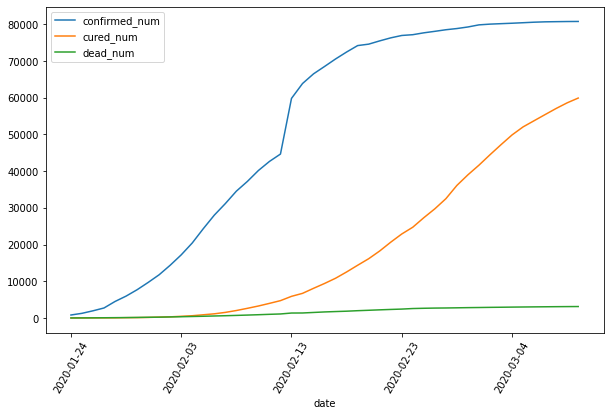

In [5]:
df = pd.read_csv('../data/covid-19.csv', sep='\t')
df.plot(x='date', y=['confirmed_num', 'cured_num', 'dead_num'], figsize=(10, 6))
plt.xticks(rotation=60)

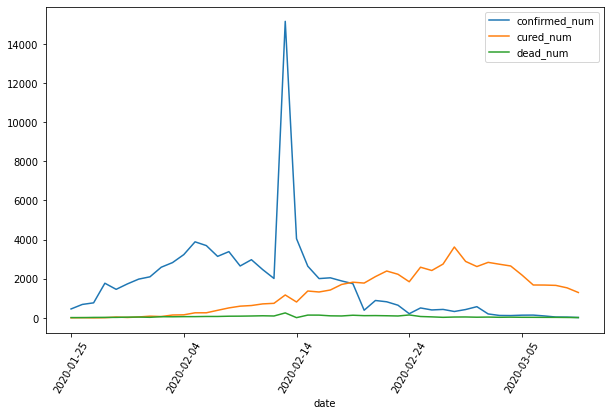

In [6]:
df_data = df.set_index('date')
df_diff = df_data.diff(periods=1).dropna()
df_diff = df_diff.reset_index('date')

df_diff.plot(x='date', y=['confirmed_num', 'cured_num', 'dead_num'], figsize=(10, 6))
plt.xticks(rotation=60)
df_diff = df_diff.drop('date', axis=1).astype('float32')


In [7]:
WINDOW_SIZE =8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE, drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(df_diff.values, dtype=tf.float32))\
    .window(WINDOW_SIZE, shift=1).flat_map(batch_dataset)
ds_label = tf.data.Dataset.from_tensor_slices(tf.constant(df_diff.values[WINDOW_SIZE:], dtype=tf.float32))

ds_train = tf.data.Dataset.zip((ds_data, ds_label)).batch(38).cache()



In [8]:
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__()

    def call(self, x_input, x):
        x_out = tf.maximum((1+x)*x_input[:, -1, :], 0.0)
        return x_out

    def get_config(self):
        config = super(Block, self).get_config()
        return config


In [9]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape=(None, 3), dtype=tf.float32)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3))(x_input)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3))(x)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3))(x)
x = layers.LSTM(3, input_shape=(None, 3))(x)
x = layers.Dense(3)(x)

x = Block()(x_input, x)
model = models.Model(inputs=[x_input], outputs=[x])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0     

In [10]:
class MSPE(losses.Loss):
    def call(self, y_true, y_pred):
        err_percent = (y_true - y_pred)**2 / tf.maximum(y_true**2, 1e-7)
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent

    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

In [11]:
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=MSPE(name='MSPE'))

log_dir = './log/1-4/{}'.format(datetime.datetime.now().strftime('%Y%m%d-%H:%M:%S'))

tb_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=100)
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)
callbacks_list = [tb_callback, lr_callback, stop_callback]

history = model.fit(ds_train, epochs=500, callbacks=callbacks_list)

Epoch 1/500
      1/Unknown - 3s 3s/stepWARNING:tensorflow:Reduce LR on plateau conditioned on metric `loss` which is not available. Available metrics are: lr
      1/Unknown - 3s 3s/step

UnknownError:  [_Derived_]  Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[model/lstm/StatefulPartitionedCall]] [Op:__inference_distributed_function_9924]

Function call stack:
distributed_function -> distributed_function -> distributed_function
